<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#导入所需要的包" data-toc-modified-id="导入所需要的包-1">导入所需要的包</a></span></li><li><span><a href="#数据文件基本预处理" data-toc-modified-id="数据文件基本预处理-2">数据文件基本预处理</a></span></li><li><span><a href="#制造业数据处理分析" data-toc-modified-id="制造业数据处理分析-3">制造业数据处理分析</a></span><ul class="toc-item"><li><span><a href="#数据时序性分析" data-toc-modified-id="数据时序性分析-3.1">数据时序性分析</a></span></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-3.2">数据预处理</a></span><ul class="toc-item"><li><span><a href="#1.删除缺失值过多、没有意义的特征" data-toc-modified-id="1.删除缺失值过多、没有意义的特征-3.2.1">1.删除缺失值过多、没有意义的特征</a></span></li><li><span><a href="#2.缺失值填充、去除异常值、归一化数据" data-toc-modified-id="2.缺失值填充、去除异常值、归一化数据-3.2.2">2.缺失值填充、去除异常值、归一化数据</a></span></li></ul></li><li><span><a href="#数据特征的提取和筛选" data-toc-modified-id="数据特征的提取和筛选-3.3">数据特征的提取和筛选</a></span></li><li><span><a href="#不平衡数据处理" data-toc-modified-id="不平衡数据处理-3.4">不平衡数据处理</a></span></li><li><span><a href="#使用随机森林训练机器学习模型" data-toc-modified-id="使用随机森林训练机器学习模型-3.5">使用随机森林训练机器学习模型</a></span></li></ul></li><li><span><a href="#制造业分类模型评价" data-toc-modified-id="制造业分类模型评价-4">制造业分类模型评价</a></span><ul class="toc-item"><li><span><a href="#绘制混淆矩阵" data-toc-modified-id="绘制混淆矩阵-4.1">绘制混淆矩阵</a></span></li><li><span><a href="#ROC曲线AUC值" data-toc-modified-id="ROC曲线AUC值-4.2">ROC曲线AUC值</a></span></li></ul></li><li><span><a href="#预测制造业第-6-年财务数据造假的上市公司" data-toc-modified-id="预测制造业第-6-年财务数据造假的上市公司-5">预测制造业第 6 年财务数据造假的上市公司</a></span></li></ul></div>

# 导入所需要的包

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score,confusion_matrix,auc,roc_curve
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from matplotlib import pyplot
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False  

# 数据文件基本预处理

In [2]:
stock_code =  pd.read_excel("附件1.xlsx")
company_data = pd.read_csv("附件2.csv")
feature_name = pd.read_excel("附件3.xlsx",index_col = '字段名')

In [3]:
#股票代码化为int类型
stock_code['股票代码']= [int(round(x)) for x in stock_code['股票代码']] 
#将特征全部替换成为中文
name=list(company_data.columns)
if name==list(feature_name.index):
    company_data.columns = [str(feature_name.loc[i]['含义']) + "_单位:" + str(feature_name.loc[i]['单位']) for i in name]
#添加所属行业
code_data_dict = stock_code.set_index('股票代码').T.to_dict('list')
industry = [code_data_dict[i][0] for i in list(company_data['股票代码_单位:nan'])]
company_data.insert(1,'所属行业_单位:nan',industry)

In [4]:
result =  Counter(company_data['所属行业_单位:nan'])
result = sorted(result.items(), key=lambda item:item[1],reverse=True)
result

[('制造业', 13970),
 ('信息传输、软件和信息技术服务业', 1777),
 ('批发和零售业', 974),
 ('房地产业', 703),
 ('电力、热力、燃气及水生产和供应业', 682),
 ('金融业', 657),
 ('交通运输、仓储和邮政业', 599),
 ('建筑业', 556),
 ('采矿业', 453),
 ('水利、环境和公共设施管理业', 350),
 ('文化、体育和娱乐业', 338),
 ('租赁和商务服务业', 326),
 ('科学研究和技术服务业', 305),
 ('农、林、牧、渔业', 245),
 ('综合', 96),
 ('卫生和社会工作', 71),
 ('住宿和餐饮业', 56),
 ('教育', 50),
 ('居民服务、修理和其他服务业', 5)]

In [5]:
company_data[company_data['所属行业_单位:nan'] == '制造业'].to_csv("制造业.csv",index = False,encoding='utf-8-sig')
company_data[company_data['所属行业_单位:nan'] != '制造业'].to_csv("其他行业.csv",index = False,encoding='utf-8-sig')

# 制造业数据处理分析

In [6]:
zhizaoye_data=pd.read_csv("制造业.csv")
zhizaoye_data.head()

,股票代码_单位:nan,所属行业_单位:nan,实际披露时间_单位:nan,发布时间_单位:nan,报告截止日期_单位:nan,截止日期_单位:nan,报告类型_单位:nan,会计区间_单位:nan,合并标志：1-合并，2-母公司_单位:nan,会计准则_单位:nan,...,流动资产周转率_单位:次,营业周期_单位:天/次,存货周转率_单位:次,固定资产周转率_单位:次,固定资产合计周转率_单位:次,应付账款周转天数_单位:天/次,存货周转天数_单位:nan,总资产周转率_单位:次,应收账款周转率_单位:次,是否在当年造假_单位:nan
0,4019,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,8166,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,11737,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,16479,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,16842,制造业,4,4,3,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [7]:
zhizaoye_data

,股票代码_单位:nan,所属行业_单位:nan,实际披露时间_单位:nan,发布时间_单位:nan,报告截止日期_单位:nan,截止日期_单位:nan,报告类型_单位:nan,会计区间_单位:nan,合并标志：1-合并，2-母公司_单位:nan,会计准则_单位:nan,...,流动资产周转率_单位:次,营业周期_单位:天/次,存货周转率_单位:次,固定资产周转率_单位:次,固定资产合计周转率_单位:次,应付账款周转天数_单位:天/次,存货周转天数_单位:nan,总资产周转率_单位:次,应收账款周转率_单位:次,是否在当年造假_单位:nan
0,4019,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,8166,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,11737,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,16479,制造业,3,3,2,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,16842,制造业,4,4,3,1,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13965,4992204,制造业,7,7,7,6,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13966,4992858,制造业,7,7,7,6,A,12,1,CHAS_2007,...,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13967,4993201,制造业,7,7,7,6,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13968,4998808,制造业,7,7,7,6,A,12,1,CHAS_2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 数据时序性分析

这里，我们来看到，发布时间有 2-7 年。那么，是不是每一个企业，都有 2-7 年的数据呢？

这个问题还是比较重要的，最完美的情况是，每一家企业都有 2-7 年的数据。这种情况下，在接下来的分析中，就不得不考虑数据是否有时序性了。换句话说，今年造假，是否和去年的数据有关（即使去年没造假）。

基于这个理由，我们首先来看看每一个企业是否真的都有2-7年的数据：

In [8]:
zhizaoye_data.groupby(by='股票代码_单位:nan').count()

,所属行业_单位:nan,实际披露时间_单位:nan,发布时间_单位:nan,报告截止日期_单位:nan,截止日期_单位:nan,报告类型_单位:nan,会计区间_单位:nan,合并标志：1-合并，2-母公司_单位:nan,会计准则_单位:nan,货币代码_单位:nan,...,流动资产周转率_单位:次,营业周期_单位:天/次,存货周转率_单位:次,固定资产周转率_单位:次,固定资产合计周转率_单位:次,应付账款周转天数_单位:天/次,存货周转天数_单位:nan,总资产周转率_单位:次,应收账款周转率_单位:次,是否在当年造假_单位:nan
股票代码_单位:nan,,,,,,,,,,,,,,,,,,,,,
4019,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,5
4213,5,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,4
8166,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,5
10375,2,2,2,2,2,2,2,2,2,2,...,2,2,2,0,0,0,2,2,0,1
11737,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992204,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,2
4992858,6,6,6,6,6,6,6,6,6,6,...,5,6,5,5,5,5,5,5,5,5
4993201,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,5


大部分的企业都有 6 组数据，7 − 2 + 1 = 6 7-2+1 = 67−2+1=6。所以，记住这个结论，之后我们解第二问、第三问，都应该要至少提到时序性的问题。

报告截止日期与截止日期，咋看之下好像是一样的，但仔细观察可以发现：报告截止日期总是大于截止日期，我们验证一下：

In [9]:
np.any(zhizaoye_data['报告截止日期_单位:nan'] > zhizaoye_data['截止日期_单位:nan'])

True

这里我们是否可以理解为，截止日期是规定的审计结束日期，而报告截止日期是审计结束之后，审计单位整理报告上报的日期？

如果是这样，那么（报告截止日期-截止日期），即企业拖拉症状，应该与截止日期无关才对，即两者作为随机变量应是相互独立的。于是，我们就可以用列联表的方式，用统计检验的方法，来考察两者的分布是否独立。

若独立，我们就可以将报告截止日期、截止日期，用（报告截止日期-截止日期）（即企业拖拉情况）来替换。因为一个企业拖拉的程度，更能够体现出这个企业造假的态度。

我们取原假设为：截止日期、（报告截止日期-截止日期）（下面用Δ \DeltaΔ代替）两个变量相互对立，首先构建用于独立检验的列联表：

In [10]:
df_for_table = zhizaoye_data.loc[:,['报告截止日期_单位:nan','截止日期_单位:nan']]
df_for_table['拖延时间'] = df_for_table.iloc[:,0] - df_for_table.iloc[:,1]
df_for_table = df_for_table.groupby(by=['截止日期_单位:nan','拖延时间']).count()
df_for_table

报告截止日期_单位:nan
截止日期_单位:nan 拖延时间               
1           0                88
            1              1573
            2                65
            3               155
2           0               764
            1               961
            2               314
            3               120
3           0                49
            1              1989
            2               151
            3                37
4           0                62
            1              2125
            2               105
            3                92
5           0                62
            1              2230
            2               368
6           0                34
            1              2626

从结果表中，我们可以看出，END_DATE 取 5 和 6 的时候（此时单位我们还不知，可能是天、月、年），拖延时间的最大值分别是 2 和 1。即，END_DATE_REP 的最大取值为 7。仔细回忆，我们的发布时间、实际披露时间的最大值也是为 7 。

于是，不难得出，END_DATE 和 END_DATE_REP 的单位是年

为了分析方便，我们将 END_DATE 为 5 和 6 的删除并构建列联表：

In [11]:
obs = np.zeros((4,4))
for i in range(4):
    tmp = df_for_table[4*i:4*(i+1)].values.reshape(-1)
    obs[i,:] = tmp
obs

array([[  88., 1573.,   65.,  155.],
       [ 764.,  961.,  314.,  120.],
       [  49., 1989.,  151.,   37.],
       [  62., 2125.,  105.,   92.]])

构建好列联表后，进行假设检验，结果如下：
检验统计量的值为 3521.1458225666274
p-值为 0.0

根据假设检验的结果，由于 p值为 0，所以很遗憾，我们需要拒绝原假设，并有100%的把握，可以说拖延时间和截止时间是相关的。

同上述分析，我们也需要考虑 PUBLISH_DATE 和 ACT_PUBTIME 之间的关系。来判断两者之间，是不是实际发布时间，或者大于等于发布时间

In [12]:
np.any(zhizaoye_data['实际披露时间_单位:nan']>= zhizaoye_data['发布时间_单位:nan'])

True

下面判断出发布拖延时间与发布时间作为随机变量是否相互独立。
我们先搭建一个列联表如下：

In [13]:
df_for_table2 = zhizaoye_data.loc[:,['实际披露时间_单位:nan','发布时间_单位:nan']]
df_for_table2['时间差'] = df_for_table2.iloc[:,0] - df_for_table2.iloc[:,1]
df_for_table2 = df_for_table2.groupby(by=['发布时间_单位:nan','时间差']).count()
df_for_table2

,,实际披露时间_单位:nan
发布时间_单位:nan,时间差,
2,0,414
3,0,2237
4,0,1022
5,0,2457
6,0,2274
7,0,5566


然而，从这个表可以看出，原来所有企业的实际发布时间，和发布时间都是相同的。

对于第二问和第三问，我们无法考虑时序性，因为我们需要解决类别不均衡问题。

## 数据预处理

### 1.删除缺失值过多、没有意义的特征

In [14]:
def Delete_LoseRate_Column(data,lose_rate):
    regular_list = []
    nan_list = []
    for i in list(data.columns):
        if data[i].isnull().sum()/(data.shape[0]-1) <= lose_rate:#-1不影响
            regular_list.append(i)
        else:
            nan_list.append(i)
    return regular_list,nan_list

lose_rate = 0.6
name_list,delete_list=Delete_LoseRate_Column(zhizaoye_data,lose_rate)
zhizaoye_data=zhizaoye_data[name_list]
print("删除了"+str(len(delete_list))+"列")
print("保留了"+str(len(name_list))+"列")

删除了249列
保留了115列


In [15]:
#删除非数字的、从头到尾一个值的、明显没有分类意义的
def FindToBeDelete_Col(company_data):
    NotNumCol_List = [col for col in company_data.columns.values if company_data[col].dtype == 'object']
    SameElemCol_List = [col for col in list(company_data.columns) if len(set(company_data[col]))==1]
    NoSense_List=list(company_data.columns[:6])#+list(company_data.columns[-1:])
    ToBeDelete_Col=list(set(NotNumCol_List).union(set(SameElemCol_List),set(NoSense_List)))
    return ToBeDelete_Col

In [16]:
ToBeDelete_Col=FindToBeDelete_Col(zhizaoye_data)
zhizaoye_data2=zhizaoye_data.drop(ToBeDelete_Col,axis=1)

In [17]:
#把要预测的部分行（flag为nan）删掉
zhizaoye_data2=zhizaoye_data2[pd.notnull(zhizaoye_data2['是否在当年造假_单位:nan'])]#isnull
zhizaoye_data2.head()

,货币资金_单位:元,应收票据_单位:元,应收账款_单位:元,预付款项_单位:元,其他应收款_单位:元,存货_单位:元,其他流动资产_单位:元,流动资产合计_单位:元,可供出售金融资产_单位:元,长期股权投资_单位:元,...,净利润(净亏损以“－”号填列)_单位:元,营业税金及附加_单位:元,营业外支出_单位:元,持续经营净利润_单位:元,归属于少数股东的综合收益总额_单位:元,所得税费用_单位:元,营业外收入_单位:元,少数股东损益_单位:元,营业总成本_单位:元,是否在当年造假_单位:nan
0,6.719939e+08,1.643520e+08,3.451945e+08,1.039522e+07,3584940.60,9.372176e+07,NaN,1.291554e+09,NaN,2.026086e+07,...,1.054685e+08,1505596.10,224194.93,NaN,NaN,19509143.39,16781651.83,NaN,3.885748e+08,0.0
1,1.010981e+09,2.155752e+09,2.887470e+08,1.075202e+08,85626756.05,1.049809e+09,1.080342e+07,4.709240e+09,NaN,2.530000e+04,...,3.626590e+08,28213513.69,1071702.74,NaN,NaN,52563706.01,22480726.69,NaN,4.930772e+09,0.0
2,1.502023e+09,2.688988e+07,9.517806e+08,4.157376e+07,37519236.14,6.611381e+08,3.919438e+08,3.619333e+09,1500000.0,1.503091e+08,...,3.479212e+08,8298888.47,633458.95,NaN,21722671.14,36404446.16,60365828.87,21722671.14,1.384902e+09,0.0
3,9.966031e+08,3.686740e+05,2.824134e+08,2.741431e+07,67249473.03,3.400061e+08,8.145214e+08,2.554056e+09,NaN,NaN,...,1.043842e+08,11585500.32,1727998.62,NaN,36810.52,17533501.14,18113878.30,36810.52,2.153059e+09,0.0
4,5.763404e+07,8.990000e+06,5.941825e+07,3.603420e+07,775584.93,6.985958e+07,4.721015e+05,2.331838e+08,NaN,NaN,...,5.190705e+07,1621817.64,499429.33,NaN,919215.16,8519689.96,4847047.58,919215.16,3.384751e+08,0.0


### 2.缺失值填充、去除异常值、归一化数据

In [18]:
#方便后面从列表变回dataframe
zhizaoye_data2_columns=zhizaoye_data2.columns

In [19]:
#调用KNN填充所有缺失数据
imputer = KNNImputer(n_neighbors=1)
zhizaoye_data2= imputer.fit_transform(zhizaoye_data2)
#zhizaoye_data2.fillna(0,inplace=True)

In [20]:
zhizaoye_data2=pd.DataFrame(zhizaoye_data2)
Q1 = zhizaoye_data2.quantile(0.25)
Q3 =zhizaoye_data2.quantile(0.75)
IQR = Q3 - Q1
nan_means_noproblem=zhizaoye_data2[(zhizaoye_data2 < (Q1 - 1.5 * IQR)) | (zhizaoye_data2> (Q3 + 1.5 * IQR))]
# 非空即异常
rows_not_null = nan_means_noproblem.count(axis=1) 
problem_index=rows_not_null[rows_not_null>60].index
selected_index=list(set(zhizaoye_data2.index).difference(set(problem_index)))
zhizaoye_data2=zhizaoye_data2.iloc[selected_index]
#查看异常行数据的标签情况
Counter(zhizaoye_data2.iloc[:,-1])

Counter({0.0: 10396, 1.0: 85})

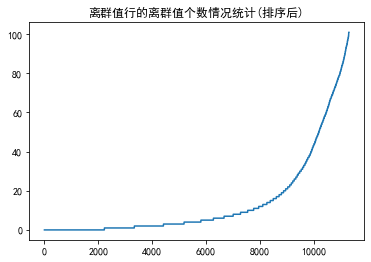

In [21]:
Sorted_rows_num=rows_not_null.sort_values()
Sorted_rows_num=Sorted_rows_num.reset_index(drop=True)
plt.title("离群值行的离群值个数情况统计(排序后)")
Sorted_rows_num.plot()
plt.show()

In [22]:
#标准化归一化
sds=StandardScaler()
zhizaoye_data2=sds.fit_transform(zhizaoye_data2)
mms = MinMaxScaler()
zhizaoye_data2= mms.fit_transform(zhizaoye_data2)

把zhizaoye_data2变回dataframe的形式

In [23]:
zhizaoye_data2=pd.DataFrame(zhizaoye_data2,columns=zhizaoye_data2_columns)
zhizaoye_data2.head()

,货币资金_单位:元,应收票据_单位:元,应收账款_单位:元,预付款项_单位:元,其他应收款_单位:元,存货_单位:元,其他流动资产_单位:元,流动资产合计_单位:元,可供出售金融资产_单位:元,长期股权投资_单位:元,...,净利润(净亏损以“－”号填列)_单位:元,营业税金及附加_单位:元,营业外支出_单位:元,持续经营净利润_单位:元,归属于少数股东的综合收益总额_单位:元,所得税费用_单位:元,营业外收入_单位:元,少数股东损益_单位:元,营业总成本_单位:元,是否在当年造假_单位:nan
0,0.043658,0.017122,0.037836,0.001069,0.001033,0.004901,0.007244,0.049369,0.004968,0.003934,...,0.601288,0.006715,0.044213,0.553713,0.629963,0.245617,0.002322,0.613349,0.010308,0.0
1,0.065686,0.224587,0.031649,0.011060,0.024677,0.054893,0.001427,0.180705,0.006369,0.002588,...,0.626670,0.022471,0.044814,0.575574,0.643846,0.267828,0.003111,0.627212,0.134279,0.0
2,0.097595,0.002801,0.104322,0.004276,0.010813,0.034570,0.051774,0.138822,0.000239,0.012587,...,0.625216,0.010722,0.044503,0.568297,0.638237,0.256970,0.008353,0.621611,0.037501,0.0
3,0.064752,0.000038,0.030954,0.002820,0.019381,0.017779,0.107595,0.097885,0.021850,0.019459,...,0.601181,0.012661,0.045280,0.559866,0.626331,0.244289,0.002507,0.609722,0.058466,0.0
4,0.003736,0.000937,0.006513,0.003706,0.000224,0.003653,0.000062,0.008697,0.004843,0.002611,...,0.596002,0.006783,0.044408,0.550140,0.626816,0.238232,0.000671,0.610205,0.008940,0.0


## 数据特征的提取和筛选

高相关滤波（High Correlation filter）

In [24]:
def HighCorrelationFilter(data,index_column):
    corr = data.loc[:, index_column].corr()
    for i in index_column:
        for j in index_column:
            if corr[i][j] > 0.8 and i != j:  # setting the threshold as 20%
                index_column.remove(j)
    new_columns = index_column
    return new_columns

zhizaoye_data2_columns=HighCorrelationFilter(zhizaoye_data2,list(zhizaoye_data2_columns))
zhizaoye_feature_data=zhizaoye_data2[zhizaoye_data2_columns]
print("处理之后特征的个数变为：",len(zhizaoye_data2_columns))

处理之后特征的个数变为： 71


In [25]:
X = np.array(zhizaoye_feature_data.iloc[:,:-1])
y = np.array(zhizaoye_feature_data['是否在当年造假_单位:nan'])
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)

前十个重要的特征： ['营业外支出_单位:元', '资产减值损失_单位:元', '资产处置收益_单位:元', '其他应收款_单位:元', '应付利息_单位:元', '未分配利润_单位:元', '收到其他与经营活动有关的现金_单位:元', '实收资本(或股本)_单位:元', '其他应付款_单位:元', '营业外收入_单位:元']


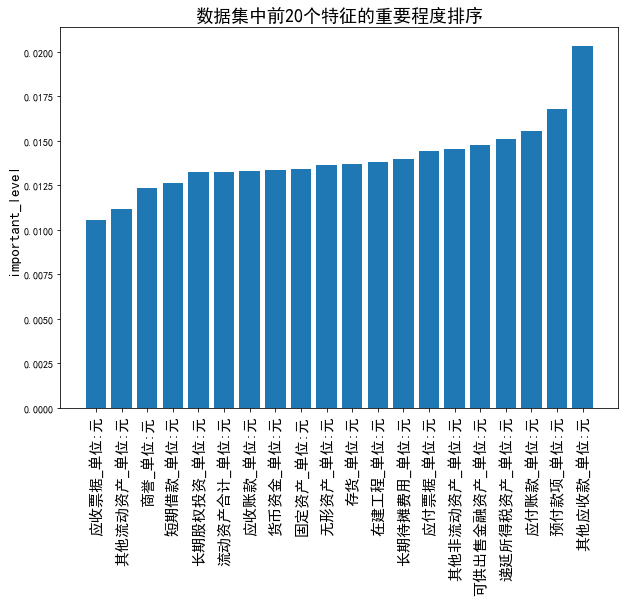

In [26]:
#打印前十个重要特征
arr = np.array(clf.feature_importances_  )
vital_columns=[zhizaoye_feature_data.columns[i] for i in np.argsort(-arr)]
print("前十个重要的特征：",vital_columns[:10])
#做特征重要程度表
bar_values=np.sort(arr[:20])
x_labels=[zhizaoye_feature_data.columns[i] for i in np.argsort(arr[:20])]
plt.figure(figsize=(10,7))
plt.title("数据集中前20个特征的重要程度排序",fontsize = 18)
plt.ylabel("important_level",fontsize = 15,rotation=90)
plt.bar(range(len(bar_values)), bar_values)
plt.xticks(np.arange(len(bar_values)),x_labels,rotation=90,fontsize=15)
plt.show()

In [27]:
selected_features=vital_columns[:10]
selected_features.append('是否在当年造假_单位:nan')
selected_features.remove('资产减值损失_单位:元')
zhizaoye_feature_data=zhizaoye_feature_data[selected_features]
zhizaoye_feature_data.head()

,营业外支出_单位:元,资产处置收益_单位:元,其他应收款_单位:元,应付利息_单位:元,未分配利润_单位:元,收到其他与经营活动有关的现金_单位:元,实收资本(或股本)_单位:元,其他应付款_单位:元,营业外收入_单位:元,是否在当年造假_单位:nan
0,0.044213,0.930841,0.001033,0.000016,0.499127,0.000921,0.033077,0.000051,0.002322,0.0
1,0.044814,0.930882,0.024677,0.002191,0.532504,0.004560,0.059740,0.015625,0.003111,0.0
2,0.044503,0.942960,0.010813,0.000570,0.519269,0.013909,0.074565,0.009045,0.008353,0.0
3,0.045280,0.931540,0.019381,0.000986,0.505436,0.001654,0.026910,0.004275,0.002507,0.0
4,0.044408,0.930882,0.000224,0.000082,0.491508,0.000575,0.005606,0.000018,0.000671,0.0


## 不平衡数据处理

查看数据标签比例情况

In [28]:
Counter(zhizaoye_feature_data['是否在当年造假_单位:nan'])

Counter({0.0: 10396, 1.0: 85})

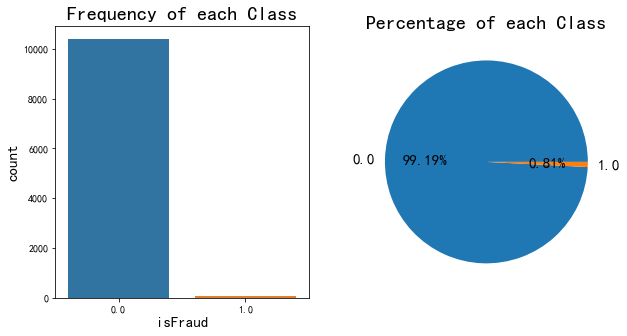

In [29]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

sns.countplot(ax=axs[0],x='是否在当年造假_单位:nan',data=zhizaoye_feature_data)
axs[0].set_xlabel("isFraud",fontsize=15)
axs[0].set_ylabel("count",fontsize=15)
axs[0].set_title("Frequency of each Class",fontsize=20)

zhizaoye_feature_data['是否在当年造假_单位:nan'].value_counts().plot(ax=axs[1],kind='pie',autopct='%1.2f%%',label="",fontsize=15)
axs[1].set_title("Percentage of each Class",fontsize=20)

plt.show()

In [30]:
X_train,X_test,y_train,y_test=train_test_split(zhizaoye_feature_data.iloc[:,:-1],
                                               zhizaoye_feature_data['是否在当年造假_单位:nan'],
                                               test_size=0.3, random_state=44)

In [31]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_train_resampled, y_train_resampled = smote_enn.fit_sample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

[(0.0, 6283), (1.0, 7203)]


## 使用随机森林训练机器学习模型

In [32]:
class_weight = dict({0:1, 1:1})
forest = RandomForestClassifier(
#与表单中的类关联的权重。如果没有给出，所有类都应该有一个权重。
   class_weight=class_weight,
#树的最大深度。如果没有，则扩展节点直到所有叶子
            max_depth=8,
            n_estimators=50,
            min_samples_split=4,
            min_samples_leaf=4,
            min_weight_fraction_leaf=0.2,
            random_state=3
    
)
forest.fit(X_train_resampled, y_train_resampled)
print(forest.score(X_test,y_test))#0.7best

0.6931637519872814


# 制造业分类模型评价

## 绘制混淆矩阵

In [33]:
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.Paired)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [34]:
Counter(y_test)

Counter({0.0: 3121, 1.0: 24})

[[2164  957]
 [   8   16]]


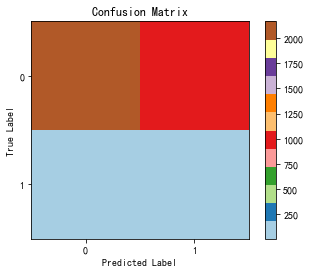

In [35]:
y_pre = forest.predict(X_test)
C=confusion_matrix(y_test, y_pre)
print(C)
plot_confusion_matrix(C)

## ROC曲线AUC值

In [36]:
fpr, tpr, thresholds=roc_curve(y_test, y_pre,pos_label=None,sample_weight=None,drop_intermediate=True)

In [37]:
def plot_roc(labels, predict_prob,name):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC'+"_" +name)
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

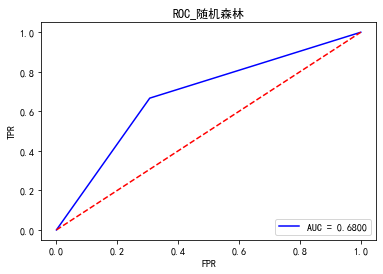

In [38]:
plt.figure()
plot_roc(y_test, y_pre,'随机森林')
#plot_roc(Ytest,y_pre_cgbc,'XGBoost')

保存模型

In [39]:
joblib.dump(forest,"forest_制造业.pkl")

['forest_制造业.pkl']

# 预测制造业第 6 年财务数据造假的上市公司

In [40]:
zhizaoye0 = pd.read_csv(r'制造业.csv')
zhizaoye0=zhizaoye0[pd.isnull(zhizaoye0['是否在当年造假_单位:nan'])]
zhizaoye0=zhizaoye0[['股票代码_单位:nan']+selected_features]
zhizaoye0=zhizaoye0.reset_index(drop="True")

In [41]:
zhizaoye=zhizaoye0.iloc[:,1:-1]
#方便后面从列表变回dataframe
zhizaoye_columns=zhizaoye.columns
#调用KNN填充所有缺失数据
imputer = KNNImputer(n_neighbors=1)
zhizaoye= imputer.fit_transform(zhizaoye)
zhizaoye=pd.DataFrame(zhizaoye)

In [42]:
#除掉异常值
Q1 = zhizaoye.quantile(0.25)
Q3 =zhizaoye.quantile(0.75)
IQR = Q3 - Q1
nan_means_noproblem=zhizaoye[(zhizaoye < (Q1 - 1.5 * IQR)) | (zhizaoye> (Q3 + 1.5 * IQR))]
rows_not_null = nan_means_noproblem.count(axis=1) 
problem_index=rows_not_null[rows_not_null>60].index
selected_index=list(set(zhizaoye.index).difference(set(problem_index)))
zhizaoye=zhizaoye.iloc[selected_index]

In [43]:
#标准化归一化
sds=StandardScaler()
zhizaoye=sds.fit_transform(zhizaoye)
mms = MinMaxScaler()
zhizaoye= mms.fit_transform(zhizaoye)
zhizaoye=pd.DataFrame(zhizaoye,columns=zhizaoye_columns)
zhizaoye.head()

,营业外支出_单位:元,资产处置收益_单位:元,其他应收款_单位:元,应付利息_单位:元,未分配利润_单位:元,收到其他与经营活动有关的现金_单位:元,实收资本(或股本)_单位:元,其他应付款_单位:元,营业外收入_单位:元
0,0.004582,0.065226,0.005859,0.001642,0.086819,0.020577,0.015786,0.000943,0.000488
1,0.005016,0.063105,0.000184,0.000166,0.088417,0.001937,0.008930,0.001695,0.001737
2,0.005048,0.106223,0.003579,0.000061,0.096761,0.005905,0.016813,0.005357,0.001103
3,0.004187,0.063102,0.000158,0.000038,0.083168,0.001235,0.002238,0.000122,0.000223
4,0.004503,0.071288,0.005864,0.000576,0.097554,0.034471,0.050607,0.000929,0.017010


In [44]:
flag_list=forest.predict(zhizaoye)

In [45]:
zhizaoye['预测是否在当年造假_单位:nan']=flag_list
Counter(flag_list)

Counter({0.0: 2117, 1.0: 543})

In [46]:
zhizaoye0[zhizaoye['预测是否在当年造假_单位:nan']==1]['股票代码_单位:nan'].to_csv("result_2.csv",index=False)